<a href="https://colab.research.google.com/github/ragyeongyoon/BNCS401-recidivism-prediction/blob/main/recidivism_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Colab에 데이터 업로드 및 라이브러리 임포트

In [36]:
# 1. 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.exceptions import ConvergenceWarning
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 2. 데이터 불러오기
file_path = './data/3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv'
full_data = pd.read_csv(file_path)

print("데이터 모양:", full_data.shape)
full_data.head()

데이터 모양: (26020, 17)


,Fiscal Year Released,Recidivism Reporting Year,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Days to Return,Recidivism Type,New Offense Classification,New Offense Type,New Offense Sub Type,Target Population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,433.0,New,C Felony,Drug,Trafficking,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,453.0,Tech,NaN,NaN,NaN,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,832.0,Tech,NaN,NaN,NaN,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,116.0,Tech,NaN,NaN,NaN,No


2. 데이터 전처리 및 탐색 (EDA)

In [51]:
## 데이터 전처리
# 종속 변수 설정: 'Return to Prison' 컬럼을 0과 1로 변환
full_data['Recidivism'] = full_data['Return to Prison'].apply(lambda x: 1 if x == 'Yes' else 0)

# 독립 변수 선택 - 재범 발생 후 알 수 있는 정보인 Data Leakage 제외
features_to_use = [
    "Main Supervising District",
    "Release Type",
    "Race - Ethnicity",
    "Age At Release ",  #Feature 뒤에 있는 공백 주의 (KeyError 해결)
    "Sex",
    "Offense Classification",
    "Offense Type",
    "Offense Subtype"
]

# 불필요한 컬럼 및 결측치가 있는 행 제거
df_cleaned = full_data[features_to_use + ['Recidivism']].dropna().copy()

print("전처리 후 데이터 모양:", df_cleaned.shape)

# 데이터 분리 (학습용 / 테스트용)
X = df_cleaned[features_to_use]
y = df_cleaned['Recidivism']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("학습 데이터 수:", len(X_train))
print("테스트 데이터 수:", len(X_test))

# 타겟 변수 분포 확인
print("\n학습 데이터 재범률 분포:")
print(y_train.value_counts(normalize=True))

전처리 후 데이터 모양: (16438, 9)
학습 데이터 수: 13150
테스트 데이터 수: 3288

학습 데이터 재범률 분포-데이터 불균형 확인:
Recidivism
0    0.596502
1    0.403498
Name: proportion, dtype: float64


3. 모델링 파이프라인 구축 및 학습
OneHotEncoder를 Pipeline과 함께 사용

In [38]:
# 모델링 파이프라인 생성 (OneHotEncoder + 모델)

# Softmax (Logistic Regression) 모델 파이프라인
softmax_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('model', LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, max_iter=1000))
])

# 모델 학습
softmax_pipeline.fit(X_train, y_train)

print("Softmax 모델 학습 완료!")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Softmax 모델 학습 완료!


4. Softmax 모델 평가

--- Softmax 모델 평가 결과 ---
정밀도 (Precision): 0.5607
재현율 (Recall): 0.2645
F1-Score: 0.3594
AUC: 0.6402



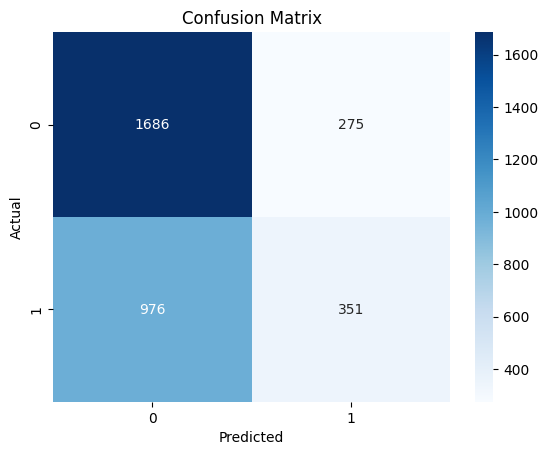

In [39]:
# 5. 모델 평가 함수 정의
def evaluate_model(pipeline, X_test, y_test):
    # 예측
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # 재범(1)일 확률

    # 성능 지표 계산
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"정밀도 (Precision): {precision:.4f}")
    print(f"재현율 (Recall): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}\n")

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix-Softmax')
    plt.show()

# Softmax 모델 평가
print("--- Softmax 모델 평가 결과 ---")
evaluate_model(softmax_pipeline, X_test, y_test)

데이터 불균형 처리 - Class_weight를 적용한 Softmax 모델 학습

In [53]:
# 데이터 불균형 확인
print("\n학습 데이터 재범률 분포- 데이터 불균형 확인:")
print(y_train.value_counts(normalize=True))
print("\n")


학습 데이터 재범률 분포-데이터 불균형 확인:
Recidivism
0    0.596502
1    0.403498
Name: proportion, dtype: float64


--- (개선) Softmax 모델 학습 및 평가 ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


[Balanced Softmax 평가 결과]
정밀도 (Precision): 0.4902
재현율 (Recall): 0.6383
F1-Score: 0.5545
AUC: 0.6402



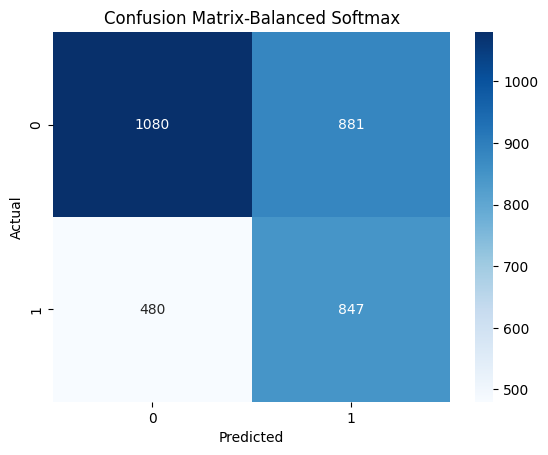

In [57]:
# class_weight='balanced'를 적용한 Softmax 모델
print("--- (개선) Softmax 모델 학습 및 평가 ---")
softmax_balanced_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('model', LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10,
                                 # 핵심 코드! 클래스 가중치 균형 맞추기
                                 class_weight='balanced',
                                 max_iter=1000))
])

softmax_balanced_pipeline.fit(X_train, y_train)

def evaluate_model(pipeline, X_test, y_test, model_name="Model"):
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"[{model_name} 평가 결과]")
    print(f"정밀도 (Precision): {precision:.4f}")
    print(f"재현율 (Recall): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}\n")

#Balanced Softmax Heatmap 보기
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix-Balanced Softmax')
    plt.show()
    return {'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

# Softmax 모델 평가
softmax_results = evaluate_model(softmax_balanced_pipeline, X_test, y_test, model_name="Balanced Softmax")

 class_weight를 적용한 Neural Network 모델

In [42]:
print("--- (개선) Neural Network 모델 학습 및 평가 ---")

# 신경망은 입력으로 숫자만 받음 -> OneHotEncoder를 먼저 적용
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

--- (개선) Neural Network 모델 학습 및 평가 ---


In [43]:
import tensorflow as tf
from tensorflow import keras

# 신경망 모델 정의
def build_nn_model(input_shape):
    model = keras.models.Sequential([
        keras.layers.Dense(64, activation="relu", input_shape=input_shape),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid") # 이진 분류이므로 sigmoid 사용
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

nn_model = build_nn_model(X_train_encoded.shape[1:])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
# 클래스 가중치 계산 (scikit-learn의 로직을 그대로 가져와 사용)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# 모델 학습 (class_weight 적용)
history = nn_model.fit(
    X_train_encoded, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    # 핵심 코드! 클래스 가중치 적용
    class_weight=class_weights_dict,
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=0 # 학습 과정 로그 생략
)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


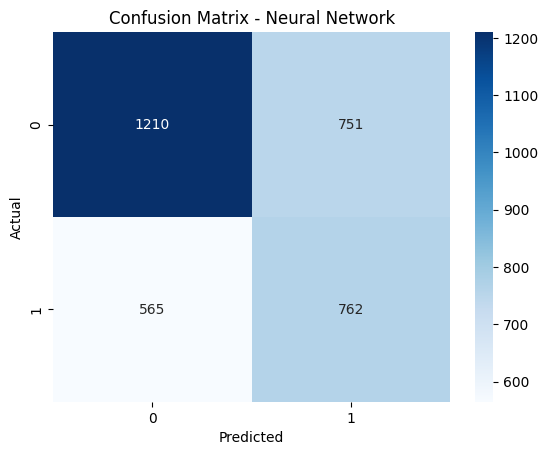

[Neural Network 평가 결과]
정밀도 (Precision): 0.5036
재현율 (Recall): 0.5742
F1-Score: 0.5366
AUC: 0.6402



In [50]:
# 신경망 모델 평가
y_pred_nn_proba = nn_model.predict(X_test_encoded).ravel()
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)

precision_nn, recall_nn, f1_nn, _ = precision_recall_fscore_support(y_test, y_pred_nn, average='binary')
auc_nn = roc_auc_score(y_test, y_pred_nn_proba)
nn_results = {'precision': precision_nn, 'recall': recall_nn, 'f1': f1_nn, 'auc': auc_nn}

# 1. 신경망 모델의 혼동 행렬 계산
cm_nn = confusion_matrix(y_test, y_pred_nn)

# 2. Seaborn을 사용해 히트맵으로 시각화
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

print("[Neural Network 평가 결과]")
print(f"정밀도 (Precision): {precision_nn:.4f}")
print(f"재현율 (Recall): {recall_nn:.4f}")
print(f"F1-Score: {f1_nn:.4f}")
print(f"AUC: {auc_nn:.4f}\n")


GitHub에 업로드

In [46]:
#requirement.txt 생성
!pip freeze > requirements.txt